# Pytorch
Ejemplo de clasificador con Pytorch, comentado en español. 

El cuaderno de Jupyter se ha desarrollado con Visual Code y puedes encontrar el código en https://github.com/josegemez/pytorch_mnist 

Se ha desarrollado en python 3.10.4 

## Import
Con las primeras lineas vamos a importar los paquetes que básicos de Pytorch. 

In [81]:
import torch
import torchvision

## Variables Generales

In [82]:
batch_size_train = 256

## Transformaciones 

In [83]:
transforms=torchvision.transforms.Compose([
                            torchvision.transforms.ToTensor(),
                            torchvision.transforms.Normalize((0.1307,), (0.3081,))
                            ])

## Dataset Entrenamiento

In [84]:
dataset_mnist = torchvision.datasets.MNIST('/files/', train=True, download=True, transform=transforms)                    

## Dataloader

In [85]:
train_loader = torch.utils.data.DataLoader(dataset_mnist,  batch_size=batch_size_train, shuffle=True,num_workers=1,pin_memory=True)

Vamos a ver que "pinta" tiene cada elemento del cargador

In [86]:
x, y = next(iter(train_loader)) #asignamos el primer batch a las variables x e y. La variable X contrendra las imagenes e y contrendra las etiquetas

In [87]:
x.shape

torch.Size([256, 1, 28, 28])

x es un batch, por lo que la primera dimensión coincidira con el batch size 

In [88]:
from matplotlib.pyplot import imshow

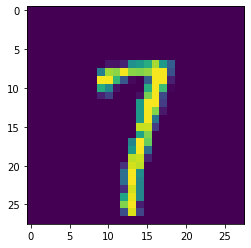

In [89]:
imshow(x[0].view(28,28).numpy()); # transformamos el primer elemento del batch una matriz de numpy y mostramos con matplotlib

In [90]:
y

tensor([7, 6, 5, 1, 1, 3, 3, 4, 5, 7, 9, 8, 7, 9, 1, 9, 3, 2, 0, 6, 4, 1, 0, 8,
        3, 4, 4, 9, 7, 1, 6, 6, 1, 9, 8, 3, 7, 0, 3, 7, 4, 9, 2, 2, 6, 4, 6, 5,
        0, 9, 8, 1, 9, 7, 7, 0, 8, 5, 7, 5, 2, 4, 2, 3, 3, 3, 8, 6, 6, 6, 8, 5,
        2, 9, 5, 8, 1, 3, 3, 7, 3, 2, 5, 4, 5, 8, 8, 0, 1, 2, 1, 4, 4, 0, 1, 7,
        5, 1, 9, 5, 6, 0, 3, 4, 7, 4, 6, 8, 2, 7, 1, 5, 7, 9, 0, 3, 5, 4, 1, 7,
        3, 3, 9, 9, 6, 7, 2, 2, 3, 1, 3, 2, 1, 8, 1, 0, 9, 5, 9, 1, 3, 6, 0, 4,
        0, 4, 5, 6, 0, 2, 7, 1, 2, 6, 4, 1, 5, 8, 1, 6, 7, 0, 4, 5, 4, 8, 0, 7,
        2, 2, 5, 7, 9, 8, 0, 0, 9, 6, 6, 3, 5, 0, 4, 0, 7, 4, 3, 5, 9, 0, 9, 7,
        0, 0, 2, 6, 2, 2, 8, 9, 4, 1, 4, 7, 6, 0, 7, 5, 2, 9, 8, 6, 9, 2, 7, 4,
        9, 6, 6, 6, 9, 1, 8, 7, 8, 3, 7, 4, 4, 4, 8, 0, 7, 1, 6, 6, 1, 8, 9, 4,
        3, 3, 0, 5, 7, 8, 5, 7, 9, 9, 3, 8, 5, 1, 3, 7])

## Dataset Test

In [91]:
dataset_mnist_test = torchvision.datasets.MNIST('/files/', train=False, download=True, transform=transforms)  # Train ahora se pone en False    
test_loader = torch.utils.data.DataLoader(dataset_mnist,  batch_size=batch_size_train, shuffle=True)              

Ya tenemos los datos preparados, ahora vamos a crear la red

In [92]:
learning_rate   =   0.01
momentum   =   0.5
n_epochs = 5
log_interval   =   10

In [93]:
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

In [94]:
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.conv1 = nn.Conv2d(1, 10, kernel_size=5)
        self.conv2 = nn.Conv2d(10, 20, kernel_size=5)
        self.conv2_drop = nn.Dropout2d()
        self.fc1 = nn.Linear(320, 50)
        self.fc2 = nn.Linear(50, 10)

    def forward(self, x):
        x = F.relu(F.max_pool2d(self.conv1(x), 2)) 
        x = F.relu(F.max_pool2d(self.conv2_drop(self.conv2(x)), 2))
        x = x.view(-1, 320)
        x = F.relu(self.fc1(x))
        x = F.dropout(x, training=self.training)
        x = self.fc2(x)
        return F.log_softmax(x)

In [95]:
#device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
device = torch.device('cuda')
device

device(type='cuda')

In [96]:
model = Net().to(device)
optimizer = optim.SGD(model.parameters(), lr=learning_rate,
                      momentum=momentum)

In [97]:
model

Net(
  (conv1): Conv2d(1, 10, kernel_size=(5, 5), stride=(1, 1))
  (conv2): Conv2d(10, 20, kernel_size=(5, 5), stride=(1, 1))
  (conv2_drop): Dropout2d(p=0.5, inplace=False)
  (fc1): Linear(in_features=320, out_features=50, bias=True)
  (fc2): Linear(in_features=50, out_features=10, bias=True)
)

In [98]:
train_losses = []
train_counter = []
test_losses = []
test_counter = [i*len(train_loader.dataset) for i in range(n_epochs + 1)]

In [99]:
def train(epoch):
  model.train()
  for batch_idx, (data, target) in enumerate(train_loader):
    data, target = data.to(device=device, non_blocking=True), target.to(device=device, non_blocking=True).long()
    optimizer.zero_grad()
    output = model(data)
    loss = F.nll_loss(output, target)
    loss.backward()
    optimizer.step()
    if batch_idx % log_interval == 0:
      print('Train Epoch: {} [{}/{} ({:.0f}%)]\tLoss: {:.6f}'.format(
        epoch, batch_idx * len(data), len(train_loader.dataset),
        100. * batch_idx / len(train_loader), loss.item()))
      train_losses.append(loss.item())
      train_counter.append(
        (batch_idx*64) + ((epoch-1)*len(train_loader.dataset)))
      torch.save(model.state_dict(), 'results/model.pth')
      torch.save(optimizer.state_dict(), 'results/optimizer.pth')

In [100]:
def test():
  model.eval()
  test_loss = 0
  correct = 0
  with torch.no_grad():
    for data, target in test_loader:
      data, target = data.to(device=device, non_blocking=True), target.to(device=device)
      output = model(data)
      test_loss += F.nll_loss(output, target, size_average=False).item()
      pred = output.data.max(1, keepdim=True)[1]
      correct += pred.eq(target.data.view_as(pred)).sum()
  test_loss /= len(test_loader.dataset)
  test_losses.append(test_loss)
  print('\nTest set: Avg. loss: {:.4f}, Accuracy: {}/{} ({:.0f}%)\n'.format(
    test_loss, correct, len(test_loader.dataset),
    100. * correct / len(test_loader.dataset)))

In [101]:
test()
for epoch in range(1, n_epochs + 1):
  train(epoch)
  test()

C:\Users\jose\AppData\Local\Temp\ipykernel_21800\746712537.py:17: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  return F.log_softmax(x)



Test set: Avg. loss: 2.3225, Accuracy: 5614/60000 (9%)

Train Epoch: 1 [0/60000 (0%)]	Loss: 2.361528
Train Epoch: 1 [2560/60000 (4%)]	Loss: 2.314111
Train Epoch: 1 [5120/60000 (9%)]	Loss: 2.280286
Train Epoch: 1 [7680/60000 (13%)]	Loss: 2.262894
Train Epoch: 1 [10240/60000 (17%)]	Loss: 2.242131
Train Epoch: 1 [12800/60000 (21%)]	Loss: 2.192151
Train Epoch: 1 [15360/60000 (26%)]	Loss: 2.155371
Train Epoch: 1 [17920/60000 (30%)]	Loss: 2.136831
Train Epoch: 1 [20480/60000 (34%)]	Loss: 1.999154
Train Epoch: 1 [23040/60000 (38%)]	Loss: 1.904740
Train Epoch: 1 [25600/60000 (43%)]	Loss: 1.793870
Train Epoch: 1 [28160/60000 (47%)]	Loss: 1.679193
Train Epoch: 1 [30720/60000 (51%)]	Loss: 1.512187
Train Epoch: 1 [33280/60000 (55%)]	Loss: 1.432065
Train Epoch: 1 [35840/60000 (60%)]	Loss: 1.293519
Train Epoch: 1 [38400/60000 (64%)]	Loss: 1.284943
Train Epoch: 1 [40960/60000 (68%)]	Loss: 1.227025
Train Epoch: 1 [43520/60000 (72%)]	Loss: 1.135492
Train Epoch: 1 [46080/60000 (77%)]	Loss: 1.000624
Tra

In [102]:
import matplotlib.pyplot as plt

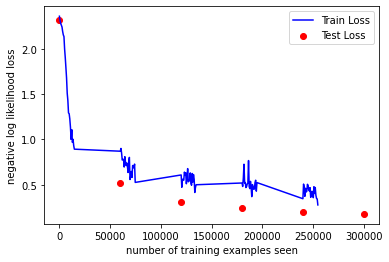

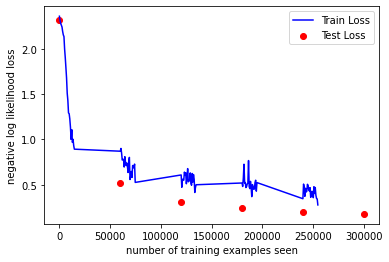

In [103]:
fig = plt.figure()
plt.plot(train_counter, train_losses, color='blue')
plt.scatter(test_counter, test_losses, color='red')
plt.legend(['Train Loss', 'Test Loss'], loc='upper right')
plt.xlabel('number of training examples seen')
plt.ylabel('negative log likelihood loss')
fig